[2025-08-19 06:09:47.593902] Generated 1000 synthetic images.


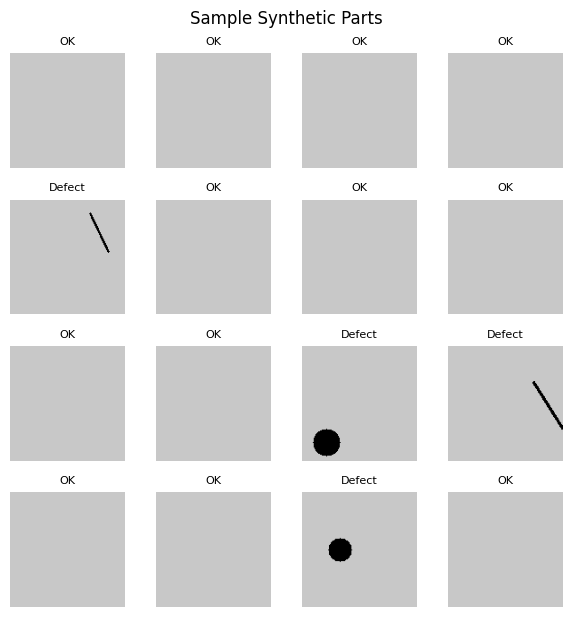

Epoch 1/5  Loss: 0.2104  Acc: 91.90%
Epoch 2/5  Loss: 0.0279  Acc: 99.50%
Epoch 3/5  Loss: 0.0024  Acc: 100.00%
Epoch 4/5  Loss: 0.0004  Acc: 100.00%
Epoch 5/5  Loss: 0.0002  Acc: 100.00%
[2025-08-19 06:10:43.286444] Model saved to checkpoints/defect_cnn.pth


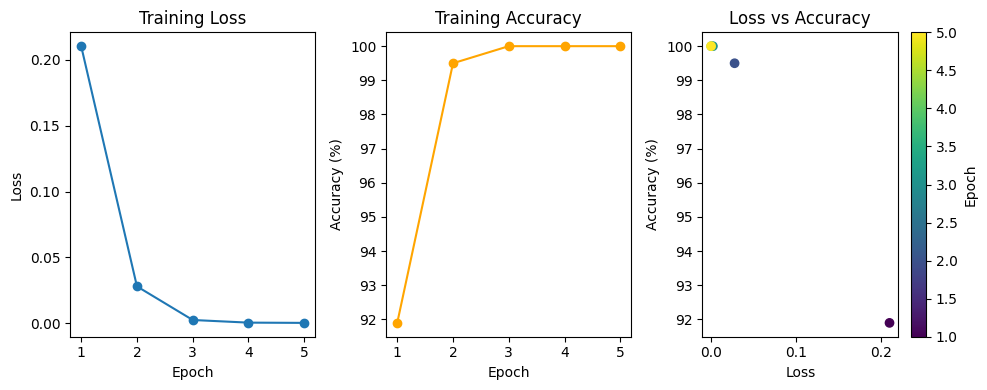

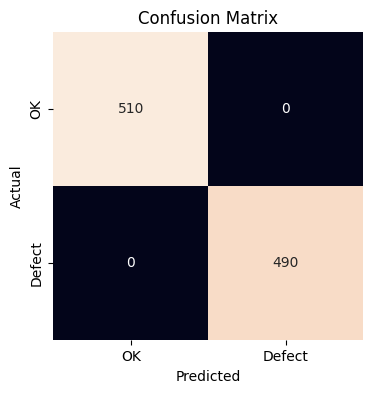

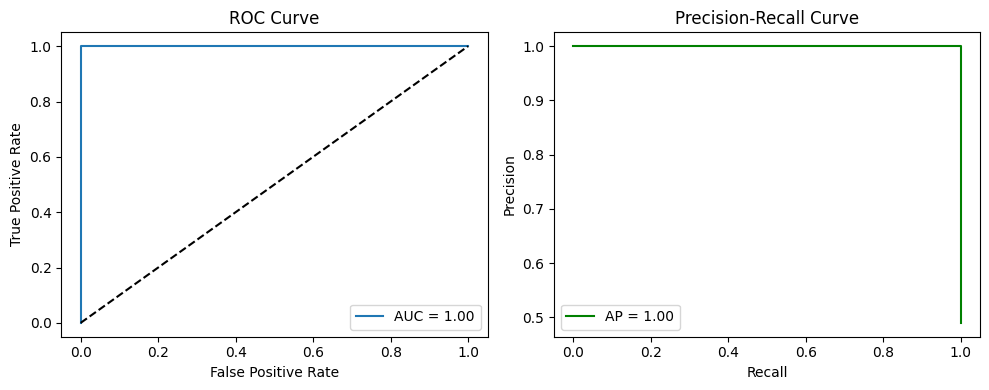

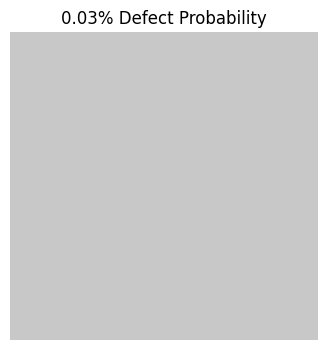

In [1]:
import os
import random
from datetime import datetime

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ------------------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------------------

DATA_DIR       = "data"
NUM_SAMPLES    = 1000
IMAGE_SIZE     = 128
DEFECT_PROB    = 0.5

EPOCHS         = 5
BATCH_SIZE     = 32
LEARNING_RATE  = 1e-3

CHECKPOINT     = "checkpoints/defect_cnn.pth"
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ------------------------------------------------------------------------------
# 1. SYNTHETIC DATA GENERATION
# ------------------------------------------------------------------------------

def generate_synthetic_data():
    os.makedirs(DATA_DIR, exist_ok=True)
    records = []
    for i in range(NUM_SAMPLES):
        img = np.full((IMAGE_SIZE, IMAGE_SIZE, 3), 200, dtype=np.uint8)
        has_defect = random.random() < DEFECT_PROB
        if has_defect:
            if random.random() < 0.5:
                center = (
                    random.randint(20, IMAGE_SIZE - 20),
                    random.randint(20, IMAGE_SIZE - 20),
                )
                cv2.circle(img, center, random.randint(5, 15), (0, 0, 0), -1)
            else:
                pt1 = (random.randint(0, IMAGE_SIZE), random.randint(0, IMAGE_SIZE))
                pt2 = (random.randint(0, IMAGE_SIZE), random.randint(0, IMAGE_SIZE))
                cv2.line(img, pt1, pt2, (0, 0, 0), 2)
        fname = f"part_{i:04d}.png"
        cv2.imwrite(os.path.join(DATA_DIR, fname), img)
        records.append((fname, int(has_defect)))
    pd.DataFrame(records, columns=["filename", "defect"]) \
      .to_csv(os.path.join(DATA_DIR, "labels.csv"), index=False)
    print(f"[{datetime.now()}] Generated {NUM_SAMPLES} synthetic images.")


# ------------------------------------------------------------------------------
# 2. VISUALIZE SAMPLE DATA
# ------------------------------------------------------------------------------

def visualize_samples(n=16):
    df = pd.read_csv(os.path.join(DATA_DIR, "labels.csv"))
    samples = df.sample(n).reset_index(drop=True)
    fig, axes = plt.subplots(int(np.sqrt(n)), int(np.sqrt(n)), figsize=(6, 6))
    for idx, ax in enumerate(axes.flatten()):
        fname, label = samples.loc[idx]
        img = Image.open(os.path.join(DATA_DIR, fname))
        ax.imshow(img)
        ax.set_title("Defect" if label else "OK", fontsize=8)
        ax.axis("off")
    plt.tight_layout()
    plt.suptitle("Sample Synthetic Parts", y=1.02)
    plt.show()


# ------------------------------------------------------------------------------
# 3. DATASET & DATALOADER
# ------------------------------------------------------------------------------

class DefectDataset(Dataset):
    def __init__(self, img_dir, labels_csv, transform=None):
        self.img_dir   = img_dir
        self.labels    = pd.read_csv(labels_csv)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        fname, label = self.labels.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, fname)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)


# ------------------------------------------------------------------------------
# 4. MODEL DEFINITION
# ------------------------------------------------------------------------------

class DefectCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(32 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), 64)
        self.fc2   = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 128→64
        x = self.pool(F.relu(self.conv2(x)))   # 64→32
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))


# ------------------------------------------------------------------------------
# 5. TRAINING LOOP WITH METRICS TRACKING
# ------------------------------------------------------------------------------

def train_model():
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.8, 0.8, 0.8), (0.2, 0.2, 0.2)),
    ])
    ds = DefectDataset(DATA_DIR, os.path.join(DATA_DIR, "labels.csv"), transform)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

    model     = DefectCNN().to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    history = {"loss": [], "accuracy": []}

    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss, correct = 0.0, 0
        for imgs, labels in dl:
            imgs, labels = imgs.to(DEVICE), labels.unsqueeze(1).to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()

        avg_loss = running_loss / len(ds)
        acc      = correct / len(ds) * 100
        history["loss"].append(avg_loss)
        history["accuracy"].append(acc)
        print(f"Epoch {epoch}/{EPOCHS}  Loss: {avg_loss:.4f}  Acc: {acc:.2f}%")

    os.makedirs(os.path.dirname(CHECKPOINT), exist_ok=True)
    torch.save(model.state_dict(), CHECKPOINT)
    print(f"[{datetime.now()}] Model saved to {CHECKPOINT}")
    return history


# ------------------------------------------------------------------------------
# 6. EVALUATION ON ENTIRE DATASET
# ------------------------------------------------------------------------------

def evaluate_model():
    # load data
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.8, 0.8, 0.8), (0.2, 0.2, 0.2)),
    ])
    df = pd.read_csv(os.path.join(DATA_DIR, "labels.csv"))
    ds = DefectDataset(DATA_DIR, os.path.join(DATA_DIR, "labels.csv"), transform)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)

    # load model
    model = DefectCNN().to(DEVICE)
    model.load_state_dict(torch.load(CHECKPOINT, map_location=DEVICE))
    model.eval()

    # collect predictions
    all_labels = []
    all_probs  = []
    with torch.no_grad():
        for imgs, labels in dl:
            imgs = imgs.to(DEVICE)
            probs = model(imgs).cpu().numpy().flatten()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy().flatten().tolist())

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)
    all_preds  = (all_probs > 0.5).astype(int)

    return all_labels, all_probs, all_preds


# ------------------------------------------------------------------------------
# 7. PLOTTING FUNCTIONS
# ------------------------------------------------------------------------------

def plot_training_history(history):
    epochs = list(range(1, len(history["loss"]) + 1))
    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.plot(epochs, history["loss"], marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1,3,2)
    plt.plot(epochs, history["accuracy"], marker='o', color='orange')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.subplot(1,3,3)
    # loss vs accuracy scatter
    plt.scatter(history["loss"], history["accuracy"], c=epochs, cmap='viridis')
    plt.title("Loss vs Accuracy")
    plt.xlabel("Loss")
    plt.ylabel("Accuracy (%)")
    plt.colorbar(label="Epoch")

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                xticklabels=["OK","Defect"], yticklabels=["OK","Defect"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def plot_roc_pr(labels, probs):
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(labels, probs)
    pr_auc = average_precision_score(labels, probs)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"AP = {pr_auc:.2f}", color='green')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------------------
# 8. INFERENCE DEMO
# ------------------------------------------------------------------------------

def predict_sample():
    sample_name = pd.read_csv(os.path.join(DATA_DIR, "labels.csv")).iloc[0].filename
    img = Image.open(os.path.join(DATA_DIR, sample_name)).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.8,0.8,0.8),(0.2,0.2,0.2)),
    ])
    inp = transform(img).unsqueeze(0).to(DEVICE)
    model = DefectCNN().to(DEVICE)
    model.load_state_dict(torch.load(CHECKPOINT, map_location=DEVICE))
    model.eval()
    with torch.no_grad():
        prob = model(inp).item() * 100

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"{prob:.2f}% Defect Probability")
    plt.axis("off")
    plt.show()


# ------------------------------------------------------------------------------
# 9. RUN FULL PIPELINE
# ------------------------------------------------------------------------------

if __name__ == "__main__":
    generate_synthetic_data()
    visualize_samples(n=16)

    history = train_model()
    plot_training_history(history)

    labels, probs, preds = evaluate_model()
    plot_confusion_matrix(labels, preds)
    plot_roc_pr(labels, probs)

    predict_sample()
